# Treasure Valley median water table, 1980 - present

To get a general idea of the thickness of the vadose zone in the Treasure Valley, I kriged median water levels from all wells in the IDWR database that had at least 5 measurements and were no deeper than 200 ft. Both DTW and altitude were kriged and averaged. The values kriged were normal scores of the values that were inverted to return true levels

For each surface, you will see:
+ An experimental semivariogram and modeled semivariogram
+ Model semivariogram parameters
+ A kriged surface
    + contour lines on the surface are the standard error
    
Below those surfaces is the averaged depth to water. I obviously need to put some wells in the SE that got cut out due to my criteria

In [105]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [80]:
import os
import pickle
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
# Kriging
from KrigingTools import drift
from WaterlevelTools import normscore
from pykrige.uk import UniversalKriging
from pykrige.core import _adjust_for_anisotropy
# Plotting
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
# GIS
import rasterio
from rasterio import warp
from shapely.geometry import LinearRing
import fiona

root = r'D:\TreasureValley\vadose\data\groundwater'
# Well datasets
datasets = ['Median1986_2018','WinterWY2016']
# Load data Median dataset
fdir = datasets[0]
with open( os.path.join(root, fdir, fdir + '.pkl' ) ,'rb') as handle:
    dataset = pickle.load(handle)

data = dataset['data'].filter(regex=r'IDTM|DTW|dtw').values
df = dataset['data'].filter(regex=r'IDTM|DTW|dtw')

In [90]:
# -----------
# Grid and geospatial
proj4str = '+proj=tmerc +lat_0=42 +lon_0=-114 +k=0.9996 +x_0=2500000 +y_0=1200000 +ellps=GRS80 +units=m +no_defs'
gridx = np.arange(2250000.0,2353000.0,500)
gridy = np.arange(1334000.0,1439000.0,500)
xll, yll = 2250000.0, 1334000.0
xur, yur = 2353000,1439000
dxy = 500.0
ncells = 210. 
#ncells = ( xur - xll)/dxy
gridx = np.arange(xll, xll + (ncells * dxy), dxy)
gridy = np.arange(yll, yll + (ncells * dxy), dxy)
#%%
fbound=r'D:\TreasureValley\notebooks\data\gis\TV_bound_2010.shp'
with fiona.open(fbound,'r') as shp:
    geoms = [feature['geometry'] for feature in shp]
    
#-----------------
# Get drift function for dtw scores
var = 4 # DTW nscores
# Krige to get similar transforms as pykrige
UK = UniversalKriging(data[:, 0], data[:, 1], data[:, var], 
                     variogram_model='exponential',weight=True,nlags=20,lagdist =1000,
                     anisotropy_angle = 10 , anisotropy_scaling=1.6)

UKgrid = UniversalKriging(gridx,gridy,gridy)

XADJ,YADJ = \
    _adjust_for_anisotropy(np.vstack((data[:, 0],data[:, 1])).T,
                          [UK.XCENTER, UK.YCENTER],
                          [UK.anisotropy_scaling],
                          [UK.anisotropy_angle]).T
gridx_adj, gridy_adj = \
    _adjust_for_anisotropy(np.vstack((gridx,gridy)).T,
                           [UKgrid.XCENTER,UKgrid.YCENTER],
                           [UK.anisotropy_scaling],
                           [UK.anisotropy_angle]).T
# Calculate drift data on adjusted coordinates
data_adj = np.vstack((XADJ,YADJ,data[:,var])).T
f = drift( data_adj, gridx_adj, gridy_adj, plot=False)

## DTW

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Using 'exponential' Variogram Model
Partial Sill: 0.6867045742339308
Full Sill: 0.7978923126447179
Range: 13458.365997351408
Nugget: 0.11118773841078707 



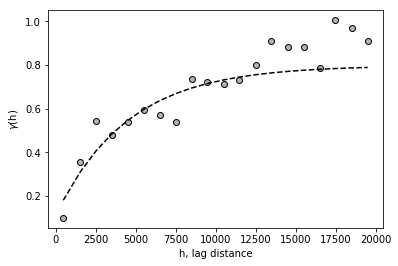

Calculating statistics on variogram model fit...
Q1 = 0.05032319912370763
Q2 = 1.1504699295177476
cR = 0.5748591865791147 

Initializing drift terms...
Executing Universal Kriging...



(1334000.0, 1438500.0)

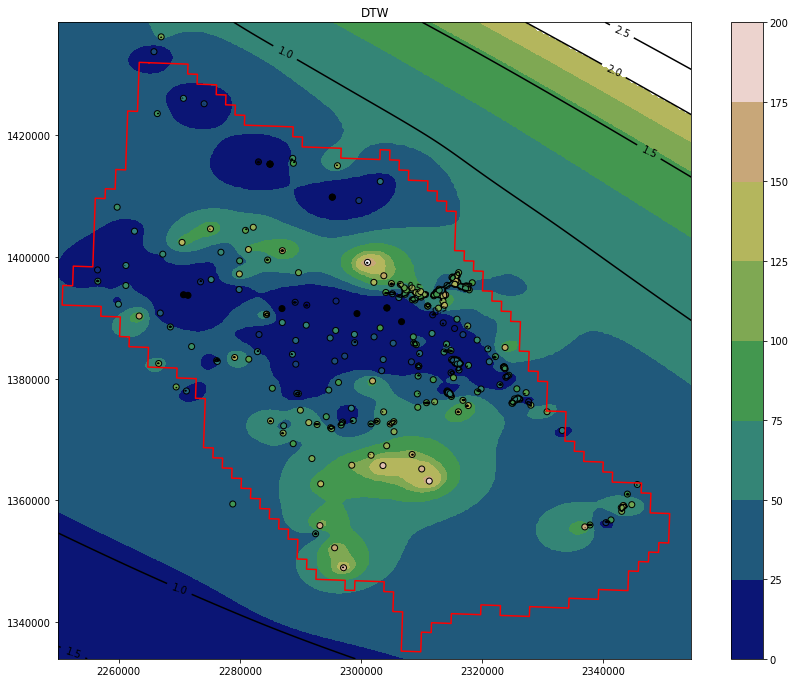

In [103]:
#-------------------------------------
# DTW NScores
var=4
UKdtw = UniversalKriging(data[:, 0], data[:, 1], data[:, var], 
                     variogram_model='exponential',weight=True,nlags=20,lagdist =1000,
                     drift_terms=['functional'],functional_drift= [f], verbose=True,
                     anisotropy_angle = 10 , anisotropy_scaling=1.6,enable_plotting=True)

# Creates the kriged grid and the variance grid---
z_dtw, ss_dtw = UKdtw.execute('grid', gridx, gridy)
z_dtw[np.sqrt(ss_dtw)> 2] = np.ma.masked
# Unmask array

# Invert the normal scores---
_,finv = normscore(df,['DTWmed'])
finv = np.vectorize(finv,otypes=[np.float])
z_dtw = finv(z_dtw)


# Plot ---
xv,yv = np.meshgrid(gridx,gridy)
ring= LinearRing(geoms[0]['coordinates'][0])

fig2, ax2 = plt.subplots(1,1,figsize=(12,12*.8))
c1 = ax2.contourf(xv,yv,z_dtw,np.arange(0,225,25),vmin=0,vmax=200,cmap='gist_earth')
plt.colorbar(c1)
ax2.plot(*ring.xy,c='r')
c2 = ax2.contour(xv,yv,np.sqrt(ss_dtw),np.arange(0,3,.5),colors='k')
ax2.scatter(data[:,0],data[:,1],c=data[:,var],cmap='gist_earth',marker='o',linewidth=1,edgecolor='k')
plt.clabel(c2,fmt = '%1.1f',inline_spacing=2)
plt.title('DTW')
plt.tight_layout()
ax2.set_ylim((gridy.min(),gridy.max()))
#ax2.scatter(data[:,0],data[:,1])

I used an anisotropy factor of 1.6 at an azimuth of 10$^\circ$ (the range of the variogram in the EW direction is 1.6x further than the NS direction)

## Altitude

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Using 'gaussian' Variogram Model
Partial Sill: 0.16744242283277727
Full Sill: 0.2004532474192712
Range: 8158.390170812688
Nugget: 0.03301082458649394 



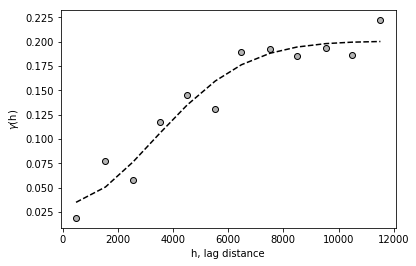

Calculating statistics on variogram model fit...
Q1 = 0.13501422744842384
Q2 = 1.899791902529723
cR = 0.1662982930001383 

Initializing drift terms...
Executing Universal Kriging...



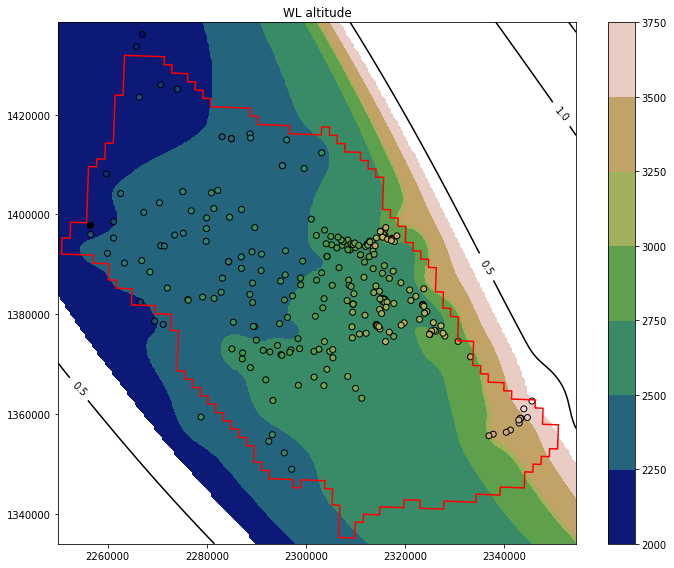

In [104]:
#%%---------------------
# ALTITUDES
var = 5 
f = drift(data[:,[0,1,var]] ,gridx, gridy,degree=3,plot=False)      
UKalt = UniversalKriging(data[:, 0], data[:, 1], data[:,5], 
                     variogram_model='gaussian',weight=True,nlags=12,lagdist=1000,
                     drift_terms=['functional'],functional_drift = [f],
                     verbose = True, enable_plotting=True)
                     
 
z_alt, ss_alt = UKalt.execute('grid', gridx, gridy)
z_alt[np.sqrt(ss_alt) > 2] = np.ma.masked
# Invert the normal scores---
_,finv = normscore(df,['ALTdtw'])
finv = np.vectorize(finv,otypes=[np.float])
z_alt = finv(z_alt)

xv,yv = np.meshgrid(gridx,gridy)
fig3,ax3 = plt.subplots(1,1,figsize=(10,8))
c1 = ax3.contourf(xv,yv,z_alt,cmap='gist_earth')
plt.colorbar(c1)
ax3.plot(*ring.xy,c='r')
ax3.scatter(data[:,0],data[:,1],c=data[:,var],cmap='gist_earth',marker='o',linewidth=1,edgecolor='k')
c2 = ax3.contour(xv,yv,np.sqrt(ss_alt),np.arange(0,3,.5),colors='k')
plt.clabel(c2, fmt = '%1.1f',inline_spacing=2)
ax3.set_title('WL altitude')
ax3.set_ylim((gridy.min(),gridy.max()))
plt.tight_layout()
#ax3.imshow(np.flipud(z_alt),vmin=vmin, vmax=vmax, extent=(gridx.min(), gridx.max(), gridy.min(), gridy.max()))
#ax3.scatter(data[:,0],data[:,1], c=data[:,5])

## Average surfaces with DEM

In [107]:
#%% ------------
# Import DEM
with rasterio.open(r'D:\TreasureValley\vadose\gis\dem.tif','r') as src:
    dem = src.read(1)
    crs = src.crs
    bounds_src = src.bounds
    affine_src = src.affine
    
# Define AFffine for kriged surfaces. Grid was defined with 500m cells
aff = rasterio.Affine(500, 0 , gridx.min(), 0, 500, gridy.min())
krige_aff = rasterio.transform.from_bounds(gridx.min(),gridy.min(),gridx.max(),gridy.max(),206,210)
krige_aff = rasterio.transform.from_origin(gridx.min() - 500/2,gridy.max()+500/2,500,500)
krige_bounds = rasterio.transform.array_bounds(210,206,krige_aff)

# Upsample to 30m for raster math
# DTW
z_dtw_us = np.empty(shape=(round(z_dtw.shape[0]/.06),round(z_dtw.shape[1]/.06)))
z_dtw_us = np.empty(shape=dem.shape)
warp.reproject(z_dtw,z_dtw_us,
               src_transform = krige_aff,
               dst_transform = affine_src,
               src_crs = crs,
               dst_crs = crs,
               resampling=warp.Resampling.nearest)
# ALT
z_alt_us = np.empty(shape=(round(z_dtw.shape[0]/.06),round(z_dtw.shape[1]/.06)))
z_alt_us = np.empty(shape=dem.shape)
warp.reproject(z_alt,z_alt_us,
               src_transform = krige_aff,
               dst_transform = affine_src,
               src_crs = crs,
               dst_crs = crs,
               resampling=warp.Resampling.nearest)

# Raster math! Average the elevations, one from subtracting depth to water 
# from the DEM and the other from the altitude
# TODO: Check to see if everything is aligned. DEM appears to be upside down...
z1=(z_dtw_us )[np.newaxis,...]
z2 = (np.flipud(dem)*3.28 - z_alt_us)[np.newaxis,...]
zavg = np.mean(np.vstack([z1,z2]),axis=0)
zavg[zavg < 0] = 0 
zavg[zavg > 600] = np.nan

In [108]:
z_avg_500 = np.empty(z_dtw.shape)
warp.reproject(zavg,z_avg_500,
               src_transform = affine_src,
               dst_transform = krige_aff,
               src_crs = crs,
               dst_crs = crs,
               resampling=warp.Resampling.nearest)

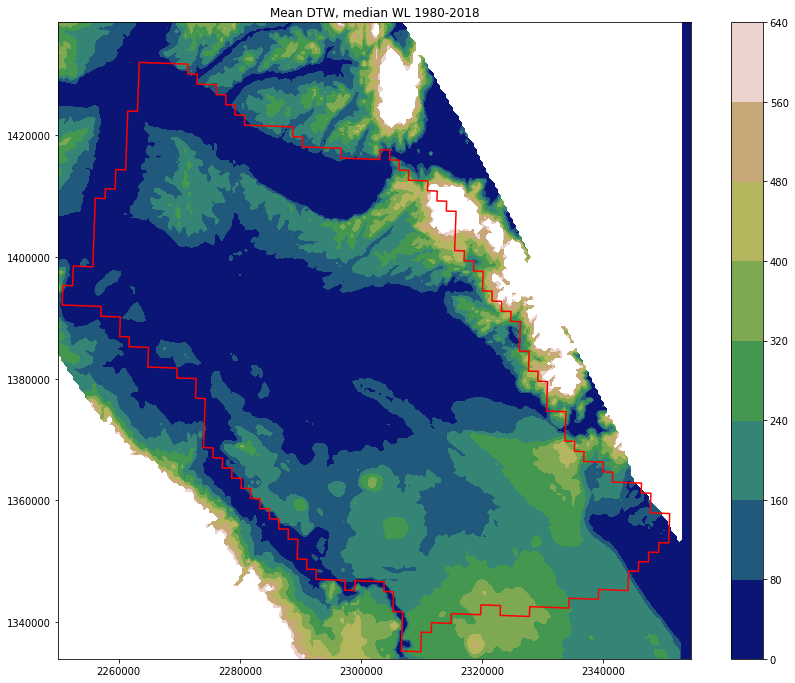

In [109]:
xv,yv = np.meshgrid(gridx,gridy)
fig4,ax4 = plt.subplots(1,1,figsize=(12,12*.8))
c1 = ax4.contourf(xv,yv,z_avg_500,cmap='gist_earth')
plt.colorbar(c1)
# Plot wells

ax4.plot(*ring.xy,c='r')
ax4.set_title('Mean DTW, median WL 1980-2018')
plt.tight_layout()